Inferencing...


  0%|          | 0/602 [00:00<?, ?it/s]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 602/602 [01:57<00:00,  5.14it/s]


tensor([[1769,   48],
        [  27,  564]], device='cuda:0')
Best threshold: 0.6332998871803284
APCER: 0.026417171582579613
BPCER 0.04568528011441231
ACER 0.036051224917173386


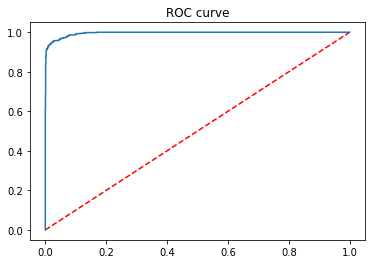

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from model.C_CDN import C_CDN,DC_CDN
from model.CDCN import CDCN, SE_CDCN, ATT_CDCN, SATT_CDCN, DATT_CDCN, BATT_CDCN, BSATT_CDCN
from model.Finetune import Finetune_model, Finetune_modelv2, WrapperClassifier
from torch.utils.data import DataLoader
from model.utils import CSDataset, CFASD_ZaloDataset, ZaloDataset, NUAADataset, StandardDataset, CFASDDataset
from torchmetrics.functional.classification import binary_confusion_matrix
from torchmetrics.functional.classification import binary_roc
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import pl_model

torch.manual_seed(42)




# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_bsatt_cdcn_best.ckpt',model = BSATT_CDCN(theta= 0.7)).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_datt_cdcn_ca_sa_last_cls_best.ckpt',model = DATT_CDCN(theta= 0.7,se = True, sa = True, pos= 'last')).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_batt_cdcn_best.ckpt',model = BATT_CDCN(theta= 0.7)).cuda()


# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_att_cdcn_ca_sa_last_cls_best.ckpt',model = ATT_CDCN(theta= 0.7,se = True, sa = True, pos= 'last')).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_att_cdcn_best.ckpt',model = ATT_CDCN(theta= 0.7,se = False, sa = False, pos= 'last')).cuda()

# val_model = Finetune_model(depth_model= ATT_CDCN(se= True,sa= True), depth_weights= 'checkpoints/checkpoint_att_cdcn_se_sa_cfas.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()
# val_model = Finetune_model(depth_model= CDCN(theta= 0.7), depth_weights= 'checkpoints/checkpoint_cdcn_cfas.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()

val_model = Finetune_model(depth_model= CDCN(theta= 0), depth_weights= 'checkpoints/checkpoint_depthnet_cfas.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()

sampler = None


pred = torch.Tensor().cuda()
target = torch.Tensor().cuda()
used_dataset = CFASDDataset(root_dir='data/processed/test_img', mode= 'val')


# print("Calculating class distribution...")
# cls_dist = np.mean([sample[2] for sample in tqdm(used_dataset)])

# print("Assigning weight to samples...")
# weight_tensor = torch.Tensor([ (1-cls_dist) if used_dataset[i][2] == 1 else cls_dist for i in tqdm(range(used_dataset.__len__())) ])
# sampler = torch.utils.data.WeightedRandomSampler(weight_tensor,int(used_dataset.__len__()*1), replacement=True)

val_model.eval()
# val_model.net.eval()
val_loader = DataLoader(used_dataset, sampler= sampler, batch_size = 4, shuffle= False)

print("Inferencing...")


with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_loader)):
        sample, spoof_label = batch[0].float().cuda(), batch[2].float().cuda()
        spoof_label = F.one_hot(spoof_label.to(torch.int64),2).float()
        # print(val_model(sample)[1])
        pred = torch.cat([pred, (val_model(sample)[1].T)[1]], dim = 0)
        
        target = torch.cat([target, (spoof_label.T)[1]], dim = 0)


roc = binary_roc(pred, target, thresholds = None)
fpr, tpr, threshold = roc[0].cpu(), roc[1].cpu(), roc[2].cpu()



best_threshold = threshold[np.argmin((((1 - tpr)+fpr)/2).numpy())]

confusion_matrix = binary_confusion_matrix(pred, target, threshold= best_threshold.item())
# confusion_matrix = binary_confusion_matrix(pred, target, threshold= .5)

print(confusion_matrix)

tn, fp, fn, tp = confusion_matrix[0,0], confusion_matrix[0,1], confusion_matrix[1,0], confusion_matrix[1,1]

apcer = fp/(tn+fp)
bpcer = fn/(tp+fn)
acer= (apcer+bpcer)/2
print("Best threshold:",best_threshold.item())
print("APCER:",apcer.item())
print("BPCER",bpcer.item())
print("ACER",acer.item())




plt.plot(fpr,fpr, 'r--')
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.show()

In [3]:
depthnet_fpr, depthnet_tpr = fpr.numpy(),tpr.numpy()

# cdcn_fpr, cdcn_tpr = fpr.numpy(),tpr.numpy()
# cls_cdcn_fpr,cls_cdcn_tpr = fpr.numpy(),tpr.numpy()
# att_cdcn_fpr, att_cdcn_tpr = fpr.numpy(),tpr.numpy()
# datt_cdcn_fpr, datt_cdcn_tpr = fpr.numpy(),tpr.numpy()
# batt_cdcn_fpr, batt_cdcn_tpr = fpr.numpy(),tpr.numpy()
# bsatt_cdcn_fpr, bsatt_cdcn_tpr = fpr.numpy(),tpr.numpy()

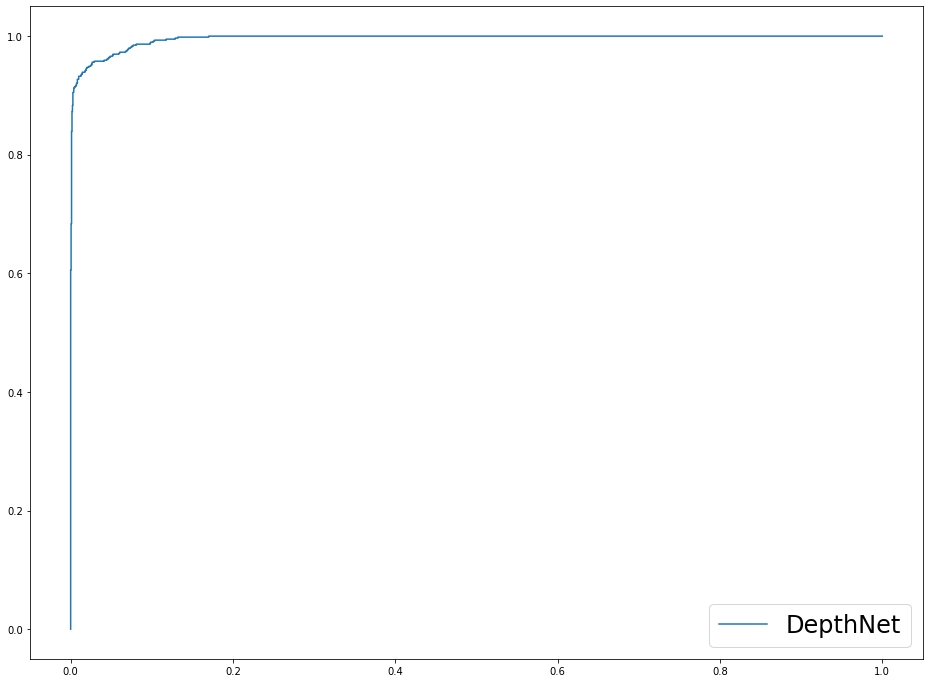

In [4]:
plt.figure(figsize = (16,12))
plt.plot(depthnet_fpr, depthnet_tpr, label = 'DepthNet')
# plt.plot(cdcn_fpr, cdcn_tpr, label = 'CDCN')

# plt.plot(cls_cdcn_fpr, cls_cdcn_tpr, label = 'CLS_CDCN')

# plt.plot(att_cdcn_fpr, att_cdcn_tpr, label = 'CATT_CDCN')
# plt.plot(datt_cdcn_fpr, datt_cdcn_tpr, label = 'DATT_CDCN')
# plt.plot(batt_cdcn_fpr, batt_cdcn_tpr, label = 'BATT_CDCN')
# plt.plot(bsatt_cdcn_fpr, bsatt_cdcn_tpr, label = 'SATT_CDCN')
plt.legend(fontsize = 24)

In [51]:
tpr = bsatt_cdcn_tpr
fpr = bsatt_cdcn_fpr


print(threshold[np.argmin((((1 - tpr)+fpr)/2))])

np.min((((1 - tpr)+fpr)/2))

tensor(0.9978)


0.19688699

In [9]:
def get_once_diff(arr):
    X = np.asarray(arr)[1:]
    X_lag = np.roll(arr,1)[1:]
    return X-X_lag

np.sum(get_once_diff(depthnet_fpr)*(np.asarray(depthnet_tpr)[1:]+np.asarray(depthnet_tpr)[:-1])/2)

0.9955822

In [11]:
eps = 1e-2

depthnet_tpr[np.max([i for i,x in enumerate(depthnet_fpr<= eps) if x])]  

0.9323181